## Derivative Dynamic Time Warping variation

"If DTW attempts to align two sequences that are similar except for local accelerations
and decelerations in the time axis, the algorithm is likely to be successful. The algorithm
has problems when the two sequences also differ in the Y-axis. Global differences,
affecting the entire sequences, such as different means (offset translation), different
scalings (amplitude scaling) or linear trends can be efficiently removed (Keogh and
Pazzani 1998, Agrawal et. al. 1995)"


Keogh, M.,J.; Pazzani, M.,J. (2006). *Derivative Dynamic Time Warping*, Computer Science University of California 

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as dist
from pandas_datareader import data as pdr
import yfinance as yfin
import tslearn
from dtw.utils import *

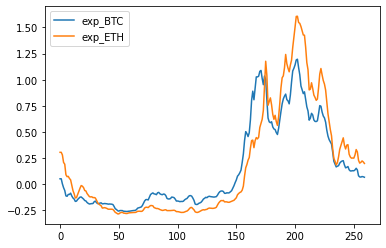

In [12]:
# Construct derivative time series
def derivative(q):
    d_q = [(q[i]-q[i-i]+(q[i+1]-q[i-1])/2)/2 for i in range(1,q.shape[0]-1)]
    return np.array(d_q)

# Construct exponential smoother
def exp_smoother(q:np.array, alpha:float = 0.1):
    exp = [q[0]]
    for i in range(1,q.shape[0]):
        exp.append(exp[i-1]+alpha*(q[i-1]-exp[i-1]))
    return np.array(exp)

d_btc = derivative(btc_normalized_close)
d_eth = derivative(eth_normalized_close)
exp_btc = exp_smoother(d_btc, 0.4)
exp_eth = exp_smoother(d_eth, 0.4)

#plt.plot(d_eth, label ='ETH')
#plt.plot(d_btc, label = 'BTC')
plt.plot(exp_btc, label = 'exp_BTC')
plt.plot(exp_eth, label = 'exp_ETH')
plt.legend()

In [13]:
x = exp_btc
y = exp_eth


# Build local distance Matrix
N = x.shape[0]
M = y.shape[0]
dist_mat = np.zeros((N,M))
for i in range(N):
    for j in range(M):
        dist_mat[i,j] = abs(x[i]-y[j])

Alignment cost: 0.2760
Normalized alignment cost: 0.0005


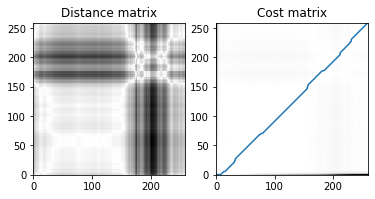

In [14]:
path, cost_mat = dp(dist_mat)
print("Alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]))
print("Normalized alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]/(N + M)))

plt.figure(figsize=(6, 4))
plt.subplot(121)
plt.title("Distance matrix")
plt.imshow(dist_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
plt.subplot(122)
plt.title("Cost matrix")
plt.imshow(cost_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_path, y_path = zip(*path)
plt.plot(y_path, x_path)

(-12.950000000000001, 271.95, -2.007632242875453, 2.9199396836075344)

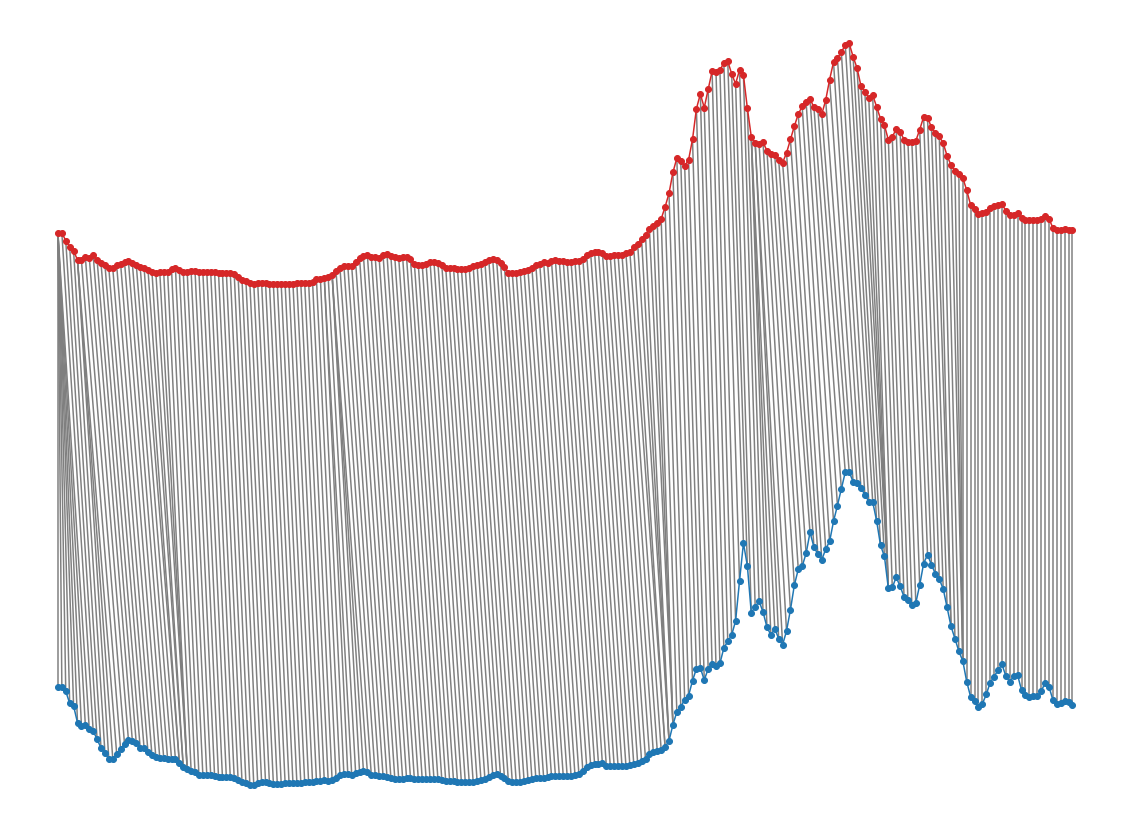

In [15]:
plt.figure(figsize=(20,15))
for x_i, y_j in path:
    plt.plot([x_i, y_j], [x[x_i] + 1.5, y[y_j] - 1.5], c="C7")
plt.plot(np.arange(x.shape[0]), x + 1.5, "-o", c="C3")
plt.plot(np.arange(y.shape[0]), y - 1.5, "-o", c="C0")
plt.axis("off")
#plt.savefig("fig/signals_a_b_align.pdf")

Results do not seem to improve even after using an exponential smoother. Next step is to explore the slope constraint in the algorithm.